In [1048]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from category_encoders import MEstimateEncoder

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [1049]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

df = pd.concat([train[train.columns], test], ignore_index=True)

In [1050]:
df.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [1051]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


In [1052]:
df.isnull().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

In [1053]:
df.rename(columns=({'Transported': 'target'}), inplace=True)

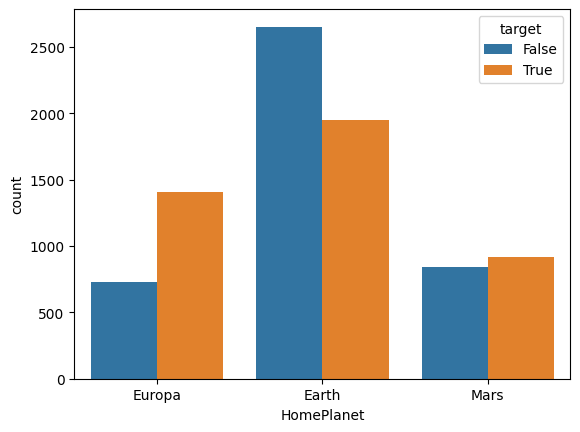

In [1054]:
sns.countplot(data=df, x='HomePlanet', hue='target');

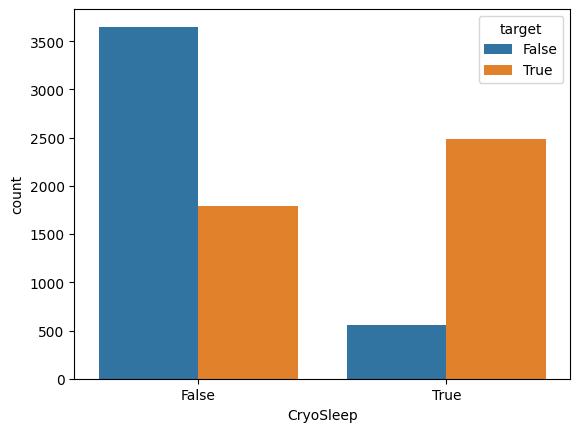

In [1055]:
sns.countplot(data=df[df['CryoSleep'].isnull() == False], x='CryoSleep', hue='target');

In [1056]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,target
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


In [1057]:
df['PassengerGroup'] = df['PassengerId'].agg(lambda s: str(s).split('_')[0])
df['CabinDeck'] = df['Cabin'].agg(lambda x: str(x).split('/')[0] if pd.notna(x) else x)
df['CabinSide'] = df['Cabin'].agg(lambda x: str(x).split('/')[2] if pd.notna(x) else x)
df['LastName'] = df['Name'].agg(lambda x: str(x).split('')[-1] if pd.notna(x) > 1 and len(str(x).split('')) > 1 else x)
df = df.drop(['Name', 'Cabin'], axis=1)


In [1058]:
cryo_index = df[df['CryoSleep'].isna() & ((df['VIP'] > 0) | (df['RoomService'] > 0) |
                                                  (df['FoodCourt'] > 0) | (df['ShoppingMall'] > 0) |
                                                  (df['Spa'] > 0) | (df['VRDeck']) > 0)].index
df.loc[cryo_index, 'CryoSleep'] = False

In [1059]:
cryo_index = df[df['CryoSleep'].isna() & ((df['VIP'] == 0) & (df['RoomService'] == 0) &
                                                  (df['FoodCourt'] == 0) & (df['ShoppingMall'] == 0) &
                                                  (df['Spa'] == 0) & (df['VRDeck']) == 0)].index
df.loc[cryo_index, 'CryoSleep'] = True

In [1060]:
df[['HomePlanet', 'Destination', 'CabinDeck',
    'CabinSide', 'LastName']] = df.groupby(by='PassengerGroup')[[
    'HomePlanet', 'Destination', 'CabinDeck', 'CabinSide', 'LastName'
    ]].transform('first').reset_index(drop=True)


In [1061]:
float_imputer = KNNImputer(n_neighbors = 3, weights='distance')
df[['Age', 'RoomService',
    'FoodCourt', 'ShoppingMall',
    'Spa','VRDeck']] = float_imputer.fit_transform(df[['Age','RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa', 'VRDeck']])

In [1062]:
df[['HomePlanet', 'Destination', 'CabinDeck',
    'CabinSide', 'LastName', 'CryoSleep', 'VIP', 'target']] =  df[['HomePlanet', 'Destination', 'CabinDeck',
                                                    'CabinSide', 'LastName', 'CryoSleep', 'VIP', 'target']].agg(
    lambda x: pd.Series(LabelEncoder().fit_transform(x[x.notnull()]), index=x[x.notnull()].index))


In [1063]:
cat_imputer = KNNImputer(n_neighbors = 1)
df[['HomePlanet', 'CryoSleep', 'Destination',
    'VIP', 'CabinDeck', 'CabinSide', 'LastName']] = cat_imputer.fit_transform(df[[
                                                            'HomePlanet',
                                                            'CryoSleep', 'Destination',
                                                            'VIP', 'CabinDeck', 'CabinSide', 'LastName']])

In [1064]:
df.isnull().sum()

PassengerId          0
HomePlanet           0
CryoSleep            0
Destination          0
Age                  0
VIP                  0
RoomService          0
FoodCourt            0
ShoppingMall         0
Spa                  0
VRDeck               0
target            4277
PassengerGroup       0
CabinDeck            0
CabinSide            0
LastName             0
dtype: int64

In [1065]:
scaler = StandardScaler()
df[['Age', 'RoomService', 'FoodCourt',
    'ShoppingMall', 'Spa', 'VRDeck']] = scaler.fit_transform(df[['Age', 'RoomService', 'FoodCourt',
    'ShoppingMall', 'Spa', 'VRDeck']])

In [1066]:
one_hot = OneHotEncoder()
df = pd.concat([df, pd.DataFrame(data=one_hot.fit_transform(df[['HomePlanet', 'Destination', 'CabinDeck']]).toarray(), columns=one_hot.get_feature_names_out())], axis=1)
df.drop(columns=['HomePlanet', 'Destination', 'CabinDeck'], inplace=True)

In [1067]:
df.drop(columns=['PassengerGroup', 'LastName'], inplace=True)

In [1068]:
data_train_final = df.iloc[:8693, :]
data_test_final = df.drop('target', axis=1).iloc[8693:, :]

X = data_train_final.drop('target', axis=1)
y = data_train_final['target']

In [1069]:
data_test_final

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinSide,...,Destination_1.0,Destination_2.0,CabinDeck_0.0,CabinDeck_1.0,CabinDeck_2.0,CabinDeck_3.0,CabinDeck_4.0,CabinDeck_5.0,CabinDeck_6.0,CabinDeck_7.0
8693,0013_01,1.0,-0.123052,0.0,-0.344478,-0.285312,-0.296151,-0.272190,-0.259159,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8694,0018_01,0.0,-0.683219,0.0,-0.344478,-0.279588,-0.296151,2.249497,-0.259159,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8695,0019_01,1.0,0.157032,0.0,-0.344478,-0.285312,-0.296151,-0.272190,-0.259159,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8696,0021_01,0.0,0.647179,0.0,-0.344478,3.945318,-0.296151,-0.110509,0.241075,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8697,0023_01,0.0,-0.613198,0.0,-0.328958,-0.285312,0.788722,-0.272190,-0.259159,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,1.0,0.367095,0.0,-0.344478,-0.285312,-0.296151,-0.272190,-0.259159,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12966,9269_01,0.0,0.927263,0.0,-0.344478,0.253374,-0.267107,-0.263258,-0.136024,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12967,9271_01,1.0,-0.123052,0.0,-0.344478,-0.285312,-0.296151,-0.272190,-0.259159,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12968,9273_01,0.0,-0.356455,0.0,-0.344478,1.419151,-0.296151,-0.272190,0.188058,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [1070]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [1071]:
param_grid  = {
    'n_estimators': [10, 20, 30],
    'max_depth': [5, 8, 10],
    'learning_rate': [0.1, 0.2, 0.3]
}

In [1072]:
grid = GridSearchCV(XGBClassifier(n_jobs=-1),param_grid, n_jobs=-1, verbose=True)

In [1073]:
grid.fit(X_train.iloc[:, 1:], y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [5, 8, 10],
                         'n_estimators': [10, 20, 30]},
             verbose=True)

In [1074]:
grid.best_params_

{'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 20}

In [1075]:
y_pred = grid.predict(X_test.iloc[:, 1:])

In [1076]:
accuracy_score(y_test, y_pred)

0.7735632183908046

In [1077]:
final_predictions = grid.predict(data_test_final.iloc[:, 1:])

In [1078]:
output = pd.DataFrame({'PassengerId': data_test_final['PassengerId'], 
                       'Transported': final_predictions.astype(bool)})
output.to_csv('submission_space.csv', index=False)